In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-01-02 21:17:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2022-01-02 21:17:56 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

MOBILENET_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

shape: (512, 512, 3)


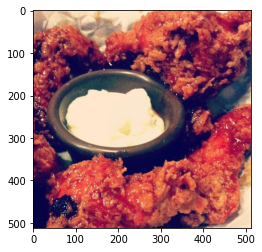

In [ ]:
import matplotlib.pyplot as plt
pic = plt.imread('/content/10_food_classes_10_percent/train/chicken_wings/1022742.jpg')
print('shape:', pic.shape)
fig, ax = plt.subplots()
ax.imshow(pic)

In [ ]:
pic.max()
# So images need rescaled

255

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=MOBILENET_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Test Images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir, 
                                                        target_size=MOBILENET_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


In [ ]:
train_data_10_percent.__getitem__(0)[0][0].shape

(224, 224, 3)

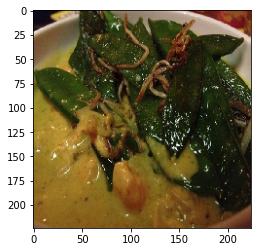

In [ ]:
plt.imshow(train_data_10_percent.__getitem__(0)[0][0])

In [ ]:
# x = tf.keras.layers.Lambda(lambda x: tf.where(tf.reduce_max(x) >= 100, (x / 255.), x))(inputs) # Better or worse?

# Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [ ]:
N_CLASSES = train_data_10_percent.num_classes

In [ ]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:
def create_model(model_url, shape, num_classes):#=N_CLASSES):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=shape+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
vanilla = create_model(mobilenet_url, MOBILENET_SHAPE)
vanilla.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
vanHist = vanilla.fit(train_data_10_percent, validation_data=test_data_10_percent,
                      epochs=5, validation_steps=int(len(test_data_10_percent)*5))

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9997 - accuracy: 0.3000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 395 batches). You may need to use the repeat() function when building your dataset.


24/24 [==============================] - 26s 849ms/step - loss: 1.9997 - accuracy: 0.3000 - val_loss: 1.2992 - val_accuracy: 0.6232
Epoch 2/5
24/24 [==============================] - 4s 176ms/step - loss: 1.0514 - accuracy: 0.7040
Epoch 3/5
24/24 [==============================] - 4s 177ms/step - loss: 0.7407 - accuracy: 0.7947
Epoch 4/5
24/24 [==============================] - 4s 180ms/step - loss: 0.5896 - accuracy: 0.8387
Epoch 5/5
24/24 [==============================] - 5s 208ms/step - loss: 0.4904 - accuracy: 0.8800


In [ ]:
(None,)+(MOBILENET_SHAPE)+(3,)

(None, 224, 224, 3)

In [ ]:
mobilenet = hub.KerasLayer(mobilenet_url, trainable=False,)

inputs = tf.keras.layers.Input(shape=(MOBILENET_SHAPE)+(3,))
x = mobilenet(inputs)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
outputs = tf.keras.layers.Dense(N_CLASSES)(x)

mnet = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
mnet.compile(optimizer='Adam', 
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'],
             )

In [ ]:
# mnetHist = mnet.fit(x=train_data_10_percent.__getitem__(0)[0], 
#                     y=train_data_10_percent.__getitem__(0)[1],
#         #  validation_data=test_data_10_percent, 
#         #  validation_steps=int(len(test_data_10_percent)*.5),
#          epochs=3,
#         #  batch_size=BATCH_SIZE,
#         use_multiprocessing=True,
#         )

In [ ]:
mnetHist = mnet.fit(train_data_10_percent,
         validation_data=test_data_10_percent, 
         validation_steps=int(len(test_data_10_percent)*.5),
         epochs=10,
         use_multiprocessing=True,
        )

Epoch 1/10
24/24 [==============================] - 21s 730ms/step - loss: 1.5885 - accuracy: 0.4880 - val_loss: 0.7779 - val_accuracy: 0.7644
Epoch 2/10
24/24 [==============================] - 16s 657ms/step - loss: 0.5861 - accuracy: 0.8160 - val_loss: 0.6454 - val_accuracy: 0.7740
Epoch 3/10
24/24 [==============================] - 16s 680ms/step - loss: 0.3559 - accuracy: 0.8907 - val_loss: 0.6081 - val_accuracy: 0.7877
Epoch 4/10
24/24 [==============================] - 16s 682ms/step - loss: 0.1780 - accuracy: 0.9667 - val_loss: 0.5990 - val_accuracy: 0.8117
Epoch 5/10
24/24 [==============================] - 16s 676ms/step - loss: 0.0836 - accuracy: 0.9933 - val_loss: 0.6013 - val_accuracy: 0.8085
Epoch 6/10
24/24 [==============================] - 17s 692ms/step - loss: 0.0449 - accuracy: 0.9973 - val_loss: 0.6176 - val_accuracy: 0.8109
Epoch 7/10
24/24 [==============================] - 16s 685ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.6165 - val_accuracy: 0.8213

In [ ]:
mobilenet = hub.KerasLayer(mobilenet_url, trainable=False,)

inputs = tf.keras.layers.Input(shape=(MOBILENET_SHAPE)+(3,))
x = mobilenet(inputs)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
outputs = tf.keras.layers.Dense(N_CLASSES)(x)

mnet2 = tf.keras.Model(inputs=inputs, outputs=outputs)
mnet2.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [ ]:
mnet2Hist = mnet2.fit(train_data_10_percent,
         validation_data=test_data_10_percent, 
         validation_steps=int(len(test_data_10_percent)*.5),
         epochs=10,
         use_multiprocessing=True,
        )

Epoch 1/10
24/24 [==============================] - 22s 745ms/step - loss: 2.4035 - accuracy: 0.1747 - val_loss: 1.8324 - val_accuracy: 0.5962
Epoch 2/10
24/24 [==============================] - 16s 662ms/step - loss: 1.8398 - accuracy: 0.3747 - val_loss: 1.3455 - val_accuracy: 0.6827
Epoch 3/10
24/24 [==============================] - 16s 680ms/step - loss: 1.5164 - accuracy: 0.4960 - val_loss: 1.0683 - val_accuracy: 0.7244
Epoch 4/10
24/24 [==============================] - 16s 690ms/step - loss: 1.2770 - accuracy: 0.5787 - val_loss: 0.9212 - val_accuracy: 0.7420
Epoch 5/10
24/24 [==============================] - 16s 669ms/step - loss: 1.1064 - accuracy: 0.6307 - val_loss: 0.7450 - val_accuracy: 0.7909
Epoch 6/10
24/24 [==============================] - 17s 694ms/step - loss: 0.9322 - accuracy: 0.6893 - val_loss: 0.6588 - val_accuracy: 0.8157
Epoch 7/10
24/24 [==============================] - 16s 669ms/step - loss: 0.8924 - accuracy: 0.6867 - val_loss: 0.6693 - val_accuracy: 0.7949

# Name 3 different image classification models on TensorFlow Hub that we haven't used.

In [ ]:
# VGG
# mobilenet (previously)
# Inception

# What is the current best performing model on ImageNet?


#### CoAtNet-7
#### top1 acc: 90.88%		
#### n-Params: 2440M
#### Paper link: https://paperswithcode.com/paper/coatnet-marrying-convolution-and-attention
#### Repository: https://paperswithcode.com/paper/coatnet-marrying-convolution-and-attention#code

# Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.

## Modification: find LR for transfer learning model

In [ ]:
from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
lr_finder = LRFinder()

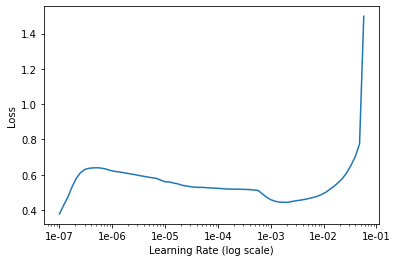

In [ ]:
mnet3 = tf.keras.Model(inputs=inputs, outputs=outputs)
mnet3.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

_ = mnet3.fit(train_data_10_percent, epochs=5, callbacks=[lr_finder], verbose=False)

lr_finder.plot()



<Figure size 1080x720 with 0 Axes>

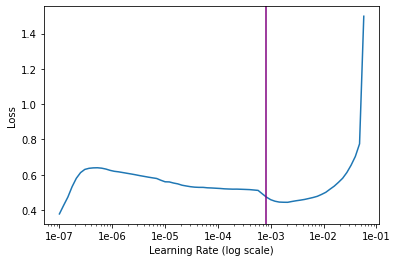

In [ ]:
plt.figure(figsize=(15,10))
lr_finder.plot()
plt.axvline(8e-04, color='purple')
plt.show()

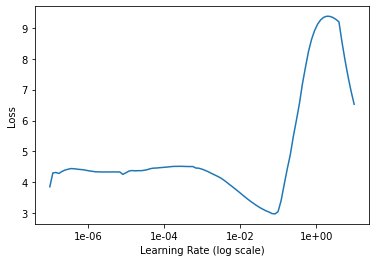

In [ ]:
mnet3.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

_ = mnet3.fit(train_data_10_percent, epochs=5, callbacks=[lr_finder], verbose=False)

lr_finder.plot()

<Figure size 1080x720 with 0 Axes>

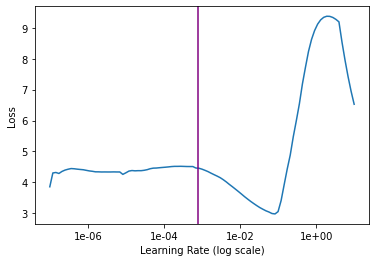

In [ ]:
plt.figure(figsize=(15,10))
lr_finder.plot()
plt.axvline(8e-04, color='purple')
plt.show()

In [ ]:
mnet3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-04), loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [ ]:
mnet3Hist = mnet3.fit(train_data_10_percent,
         validation_data=test_data_10_percent, 
         validation_steps=int(len(test_data_10_percent)*.5),
         epochs=15,
         use_multiprocessing=True,
        )

Epoch 1/15
24/24 [==============================] - 20s 746ms/step - loss: 11.6527 - accuracy: 0.1013 - val_loss: 3.0010 - val_accuracy: 0.0994
Epoch 2/15
24/24 [==============================] - 16s 688ms/step - loss: 128.3834 - accuracy: 0.1000 - val_loss: 5.7228 - val_accuracy: 0.1034
Epoch 3/15
24/24 [==============================] - 27s 1s/step - loss: 33.8835 - accuracy: 0.1000 - val_loss: 5.7358 - val_accuracy: 0.0905
Epoch 4/15
24/24 [==============================] - 16s 673ms/step - loss: 16.8476 - accuracy: 0.1013 - val_loss: 4.8405 - val_accuracy: 0.1138
Epoch 5/15
24/24 [==============================] - 16s 677ms/step - loss: 25.7642 - accuracy: 0.1000 - val_loss: 3.0563 - val_accuracy: 0.0970
Epoch 6/15
24/24 [==============================] - 16s 671ms/step - loss: 19.5212 - accuracy: 0.1000 - val_loss: 4.5433 - val_accuracy: 0.0897
Epoch 7/15
24/24 [==============================] - 16s 670ms/step - loss: 18.6827 - accuracy: 0.1000 - val_loss: 4.4536 - val_accuracy: 0

In [ ]:
# The learning rate is too small and we're working up a canyon rather than down. Here you need to adjust learning rate up one or more times to get out of the local minima. 
# I would say you can also allow this to be some target lower rate, but Adam generally works better going down from .01 if I understand correctly.

# Build a model to classify images of two different things you've taken photos of.
## You can use any feature extraction layer from TensorFlow Hub you like for this.
## You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

## Modify: pull up another dataset

In [ ]:
------------------------------------------ See TPU notebook for Art classification

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install kaggle 
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [00:27<00:00, 44.6MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.4MB/s]


In [ ]:
# import zipfile
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("best-artworks-of-all-time.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import pandas as pd
art = pd.read_csv('artists.csv', low_memory=False, index_col=0)
art.head()

,name,years,genre,nationality,bio,wikipedia,paintings
id,,,,,,,
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [ ]:
sorted(art.name.unique())[:5]

['Albrecht Dürer',
 'Alfred Sisley',
 'Amedeo Modigliani',
 'Andrei Rublev',
 'Andy Warhol']

In [ ]:
location = '/content/images/images'

In [ ]:
#Only want artists with one label...let's just truncate

In [ ]:
art.genre.str.split(',',expand=True)[:5]

,0,1,2
id,,,
0,Expressionism,None,None
1,Expressionism,Abstractionism,None
2,Social Realism,Muralism,None
3,Impressionism,None,None
4,Surrealism,Impressionism,None


In [ ]:
art['simpleGenre'] = art.genre.str.split(',',expand=True).iloc[:,0]

In [ ]:
gens = art.simpleGenre.value_counts()
gens

Impressionism             6
High Renaissance          4
Symbolism                 4
Post-Impressionism        4
Northern Renaissance      4
Baroque                   4
Romanticism               3
Expressionism             3
Primitivism               3
Surrealism                3
Realism                   2
Byzantine Art             1
Early Renaissance         1
Cubism                    1
Pop Art                   1
Suprematism               1
Proto Renaissance         1
Abstract Expressionism    1
Neoplasticism             1
Mannerism                 1
Social Realism            1
Name: simpleGenre, dtype: int64

In [ ]:
# There are not really a ton of painters in some of these categories...Can surely overfit to learn artist and style

In [ ]:
def create_new_folder(path):
    """
    Creates a new folder under given path, if it doesn't already exist
    :param path: Path where folder is created
    :return: None
    """

    if not os.path.exists(path):
        os.makedirs(path)
        print(path + ' created')
    else:
        print(path + ' path already exists')

In [ ]:
# for gen in gens.keys():
#   create_new_folder(f'./{gen}')

In [ ]:
lookup = art[['name', 'simpleGenre']]
lookup[:5]

,name,simpleGenre
id,,
0,Amedeo Modigliani,Expressionism
1,Vasiliy Kandinskiy,Expressionism
2,Diego Rivera,Social Realism
3,Claude Monet,Impressionism
4,Rene Magritte,Surrealism


In [ ]:
#Is there more than one first name? 
names = lookup.name.str.split(' ', expand=True)
names

,0,1,2
id,,,
0,Amedeo,Modigliani,None
1,Vasiliy,Kandinskiy,None
2,Diego,Rivera,None
3,Claude,Monet,None
4,Rene,Magritte,None
5,Salvador,Dali,None
6,Edouard,Manet,None
7,Andrei,Rublev,None
8,Vincent,van,Gogh


In [ ]:
names.iloc[:,0].value_counts()[:5]

Henri         3
Paul          3
Diego         2
Caravaggio    1
Francisco     1
Name: 0, dtype: int64

In [ ]:
# Close but not quite. Let's try directory style names
lookup['name'] = lookup.name.str.replace(' ', '_')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
lookup[lookup.name.str.contains('Albrecht')]

,name,simpleGenre
id,,
19,Albrecht_Dürer,Northern Renaissance


In [ ]:
newFolder = lookup[lookup.name.str.contains('Albrecht')].name.values[0]

In [ ]:
lookup[:5]

,name,simpleGenre
id,,
0,Amedeo_Modigliani,Expressionism
1,Vasiliy_Kandinskiy,Expressionism
2,Diego_Rivera,Social Realism
3,Claude_Monet,Impressionism
4,Rene_Magritte,Surrealism


In [ ]:
os.makedirs(f'{location}/{newFolder}')

In [ ]:
for folder in os.listdir(location):
  if 'Albrecht' in folder:
    print(folder)

Albrecht_DuΓòá├¬rer
Albrecht_Dürer
Albrecht_Du╠êrer


In [ ]:
!cp -a /content/images/images/Albrecht_Du*/. /content/images/images/Albrecht_Dürer

In [ ]:
# Realistically I shouldn't include durer without checking for duplicates, so I will currently ignore

In [ ]:
lookup = lookup[~lookup.name.str.contains('Albrecht')]

In [ ]:
# import shutil
# for nm, gen in zip(lookup.name, lookup.simpleGenre):
#   for filename in os.listdir(f'{location}/{nm}'):
#     shutil.copy(f'{location}/{nm}/{filename}', f'./{gen}')

### Okay, let's go a different route and load files from dataframe

In [ ]:
df = pd.DataFrame()
for nom in lookup.name:
  listed = pd.DataFrame([(nom, f'{location}/{nom}/{fil}') for fil in os.listdir(f'{location}/{nom}/')], columns=['name', 'path'])
  df = df.append(listed, ignore_index=True)

In [ ]:
lookup2 = lookup.merge(df, on='name', how='left')
lookup2

,name,simpleGenre,path
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
...,...,...,...
8113,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...
8114,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...
8115,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...
8116,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...


Shape: (807, 489, 3)


(None, <matplotlib.image.AxesImage at 0x7fe84e115990>)

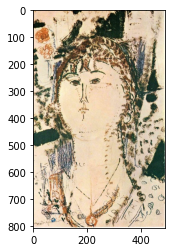

In [ ]:
img = plt.imread(lookup2.iloc[0].path)
print('Shape:', img.shape), plt.imshow(img)

In [ ]:
EFF_SHAPE = (600, 600, 3)
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [ ]:
# import numpy as np
# lookup2['TTS'] = np.random.default_rng().choice([0,1], p=[.8,.2], replace=False)
# lookup2

In [ ]:
from sklearn.model_selection import train_test_split as TTS
target = 'simpleGenre'
X = lookup2.drop(target, axis=1)
y = lookup2[target]
X_train, X_test, y_train, y_test = TTS(X, y, test_size=.2, stratify=y)
train, test = TTS(lookup2, test_size=.2, stratify=lookup2[target])

In [ ]:
train

,name,simpleGenre,path
360,Claude_Monet,Impressionism,/content/images/images/Claude_Monet/Claude_Mon...
7237,Paul_Klee,Expressionism,/content/images/images/Paul_Klee/Paul_Klee_117...
6757,William_Turner,Romanticism,/content/images/images/William_Turner/William_...
4162,Pieter_Bruegel,Northern Renaissance,/content/images/images/Pieter_Bruegel/Pieter_B...
7259,Piet_Mondrian,Neoplasticism,/content/images/images/Piet_Mondrian/Piet_Mond...
...,...,...,...
631,Salvador_Dali,Surrealism,/content/images/images/Salvador_Dali/Salvador_...
499,Rene_Magritte,Surrealism,/content/images/images/Rene_Magritte/Rene_Magr...
2095,Kazimir_Malevich,Suprematism,/content/images/images/Kazimir_Malevich/Kazimi...
1657,Vincent_van_Gogh,Post-Impressionism,/content/images/images/Vincent_van_Gogh/Vincen...


In [ ]:
test

,name,simpleGenre,path
2301,Mikhail_Vrubel,Symbolism,/content/images/images/Mikhail_Vrubel/Mikhail_...
2439,Pablo_Picasso,Cubism,/content/images/images/Pablo_Picasso/Pablo_Pic...
6753,William_Turner,Romanticism,/content/images/images/William_Turner/William_...
7437,Joan_Miro,Surrealism,/content/images/images/Joan_Miro/Joan_Miro_14.jpg
989,Vincent_van_Gogh,Post-Impressionism,/content/images/images/Vincent_van_Gogh/Vincen...
...,...,...,...
628,Salvador_Dali,Surrealism,/content/images/images/Salvador_Dali/Salvador_...
5326,Edgar_Degas,Impressionism,/content/images/images/Edgar_Degas/Edgar_Degas...
6686,Camille_Pissarro,Impressionism,/content/images/images/Camille_Pissarro/Camill...
4065,Pieter_Bruegel,Northern Renaissance,/content/images/images/Pieter_Bruegel/Pieter_B...


In [ ]:
!mkdir train | mkdir test

In [ ]:
lookup2.simpleGenre.unique()

array(['Expressionism', 'Social Realism', 'Impressionism', 'Surrealism',
       'Realism', 'Byzantine Art', 'Post-Impressionism', 'Symbolism',
       'Northern Renaissance', 'Suprematism', 'Cubism', 'Baroque',
       'Romanticism', 'Primitivism', 'Mannerism', 'Proto Renaissance',
       'Early Renaissance', 'High Renaissance', 'Neoplasticism',
       'Pop Art', 'Abstract Expressionism'], dtype=object)

In [ ]:
import shutil

for tts in ['train', 'test']:
  for nm, gen in zip(lookup2.name, lookup2.simpleGenre):
    pattern = f'/content/{tts}/{gen}/{nm}'
    if os.path.exists(pattern) == False:
      os.makedirs(pattern)

for idx, (nm, gen, pth) in train.iterrows():
  shutil.copy(pth, f'/content/train/{gen}/{nm}/')

for idx, (nm, gen, pth) in test.iterrows():
  shutil.copy(pth, f'/content/test/{gen}/{nm}/')

In [ ]:
# import shutil
# for pth in train.path:
#   shutil.copy(pth, '/content/train')
# for pth in test.path:
#   shutil.copy(pth, '/content/test')

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

# # https://cloud.google.com/resource-manager/docs/creating-managing-projects
# project_id = 'art-classification0'
# !gcloud config set project {project_id}

In [ ]:
!zip --help

Copyright (c) 1990-2008 Info-ZIP - Type 'zip "-L"' for software license.
Zip 3.0 (July 5th 2008). Usage:
zip [-options] [-b path] [-t mmddyyyy] [-n suffixes] [zipfile list] [-xi list]
  The default action is to add or replace zipfile entries from list, which
  can include the special name - to compress standard input.
  If zipfile and list are omitted, zip compresses stdin to stdout.
  -f   freshen: only changed files  -u   update: only changed or new files
  -d   delete entries in zipfile    -m   move into zipfile (delete OS files)
  -r   recurse into directories     -j   junk (don't record) directory names
  -0   store only                   -l   convert LF to CR LF (-ll CR LF to LF)
  -1   compress faster              -9   compress better
  -q   quiet operation              -v   verbose operation/print version info
  -c   add one-line comments        -z   add zipfile comment
  -@   read names from stdin        -o   make zipfile as old as latest entry
  -x   exclude the following nam

In [ ]:
# !zip -r /content/train.zip /content/train
# !zip -r /content/test.zip /content/test

In [ ]:
f
# files.download('test.zip')

In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.78.108.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.108.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# def connect_to_tpu(tpu_address: str = None):
#     if tpu_address is not None:  # When using GCP
#         cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
#             tpu=tpu_address)
#         if tpu_address not in ("", "local"):
#             tf.config.experimental_connect_to_cluster(cluster_resolver)
#         tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#         strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)
#         print("Running on TPU ", cluster_resolver.master())
#         print("REPLICAS: ", strategy.num_replicas_in_sync)
#         return cluster_resolver, strategy
#     else:                           # When using Colab or Kaggle
#         try:
#             cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#             strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)
#             print("Running on TPU ", cluster_resolver.master())
#             print("REPLICAS: ", strategy.num_replicas_in_sync)
#             return cluster_resolver, strategy
#         except:
#             print("WARNING: No TPU detected.")
#             mirrored_strategy = tf.distribute.MirroredStrategy()
#             return None, mirrored_strategy

In [ ]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [ ]:
TEST_URL = 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/*/*/*/*/*.jpg'
TRAIN_URL = 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/*/*/*/*/*.jpg'

In [ ]:
# 0 is desired outcome
!gsutil -q stat $TRAIN_URL; echo $?
!gsutil -q stat $TEST_URL; echo $?

0
0


In [ ]:
lookup2

,name,simpleGenre,path
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...
...,...,...,...
8113,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...
8114,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...
8115,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...
8116,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...


In [ ]:
lookup2['img_name'] = [i.split('/')[-1] for i in lookup2.path]
lookup2

,name,simpleGenre,path,img_name
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_42.jpg
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_85.jpg
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_166.jpg
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_188.jpg
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_92.jpg
...,...,...,...,...
8113,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_8.jpg
8114,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_19.jpg
8115,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_22.jpg
8116,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_6.jpg


In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
# enc.fit(list(lookup2.simpleGenre.unique()))
lookup2['target_encoded'] = enc.fit_transform(lookup2.simpleGenre)

In [ ]:
TRAIN_URL

'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/*/*/*/*/*.jpg'

In [ ]:
test_filenames = tf.io.gfile.glob(f'{TEST_URL[:-6]}/*.jpg')
train_filenames = tf.io.gfile.glob(f'{TRAIN_URL[:-6]}/*.jpg')
test_filenames[:5]

['gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_14.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_16.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_4.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_6.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_7.jpg']

In [ ]:
gs = pd.DataFrame(test_filenames)
gs['img_name'] = [i.split('/')[-1] for i in gs[0]]
gs.columns = ['gs_path', 'img_name']

gs2 = pd.DataFrame(train_filenames)
gs2['img_name'] = [i.split('/')[-1] for i in gs2[0]]
gs2.columns = ['gs_path', 'img_name']

In [ ]:
train = lookup2.merge(gs, on='img_name')
test = lookup2.merge(gs2, on='img_name')

In [ ]:
train_labels = {train.gs_path.iloc[i] : train.target_encoded.iloc[i] for i in range(len(train))}
test_labels = {test.gs_path.iloc[i] : test.target_encoded.iloc[i] for i in range(len(test))}

In [ ]:
"""# Create dataset from multiple .tfrecord files
list_of_tfrecord_files = [dir1, dir2, dir3, dir4]
dataset = tf.data.TFRecordDataset(list_of_tfrecord_files)"""
# This is a good lead

# train_dataset = train_files.concatenate(train_labels)

'# Create dataset from multiple .tfrecord files\nlist_of_tfrecord_files = [dir1, dir2, dir3, dir4]\ndataset = tf.data.TFRecordDataset(list_of_tfrecord_files)'

In [ ]:
# Would this work?

In [ ]:
train.columns

Index(['name', 'simpleGenre', 'path', 'img_name', 'target_encoded', 'gs_path'], dtype='object')

In [ ]:
features_dataset = tf.data.Dataset.from_tensor_slices((train.gs_path, train.target_encoded))
features_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(feature0, feature1):#, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      # 'feature0': _int64_feature(feature0),
      # 'feature1': _int64_feature(feature1),
      'feature0': _bytes_feature(feature0),
      'feature1': _float_feature(feature1),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
def tf_serialize_example(f0,f1,):#f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0, f1), # f2, f3),  # Pass these args to the above function.
    tf.string)      # The return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar.

In [ ]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [ ]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [ ]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [ ]:
filename = 'trial2.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


In [ ]:
raw_dataset = tf.data.TFRecordDataset(filename)
raw_dataset

UnimplementedError: ignored

In [ ]:
# for i in raw_dataset.take(10):
#   print(repr(i))
#   break
#   print(y)

In [ ]:
  # features = {
  #   "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
  #   "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
  #   "one_hot_class": tf.io.VarLenFeature(tf.float32),
  # }
  
  # example = tf.io.parse_single_example(example, features)
  # decoded = tf.image.decode_jpeg(example['image'], channels=3)
  # # normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  # image_tensor = tf.reshape(decoded, [224,224,3])
  # one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [N_CLASSES])
  # return image_tensor, one_hot_class

In [ ]:
# Create a description of the features.
feature_description = {
    # 'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    # 'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'class': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _parse_function2(example_proto, N_CLASSES=21):
  example = tf.io.parse_single_example(example_proto, feature_description)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  # normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(decoded, [600,600,3])
  # one_hot_class = tf.reshape(tf.sparse.to_dense(example['class']), [N_CLASSES])
  ohe = tf.one_hot(tf.cast(example['class'], tf.int32), N_CLASSES)
  return image_tensor, ohe

In [ ]:
parsed_dataset = raw_dataset.map(_parse_function2)
parsed_dataset

NameError: ignored

In [ ]:
thi = parsed_dataset.__iter__()
thi2 = next(thi)

InvalidArgumentError: ignored

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

InvalidArgumentError: ignored

In [ ]:
for parsed_record in parsed_dataset.take(1):
  print(parsed_record)

InvalidArgumentError: ignored

In [ ]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

NameError: ignored

In [ ]:
def image_example(image_string, label):
  image_shape = tf.io.decode_jpeg(image_string).shape

  feature = {
      # 'height': _int64_feature(image_shape[0]),
      # 'width': _int64_feature(image_shape[1]),
      # 'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))


In [ ]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'train.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in train_labels.items():
    # image_string = tf.io.decode_image(tf.io.read_file(filename).read())
    image_string = tf.io.read_file(filename)
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())


In [ ]:
1+1














2

In [ ]:
 record_file = 'test.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in test_labels.items():
    image_string = tf.io.read_file(filename)
    tf.example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [ ]:
from google.colab import files
files.download('test.tfrecords') 
files.download('train.tfrecords')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [N_CLASSES])

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_function2(example_proto, N_CLASSES=21):
  example = tf.io.parse_single_example(example_proto, image_feature_description)
  decoded = tf.image.decode_jpeg(example['image_raw'], channels=3)
  # print(decoded)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.image.resize_with_pad(decoded, 224, 224)#, preserve_aspect_ratio=True)
  # image_tensor = tf.cast(image_tensor, tf.float32)
  # image_tensor = decoded
  # one_hot_class = tf.reshape(tf.sparse.to_dense(example['class']), [N_CLASSES])
  ohe = tf.one_hot(tf.cast(example['label'], tf.int32), N_CLASSES)
  return image_tensor, ohe

parsed_image_dataset = raw_image_dataset.map(_parse_image_function2)
parsed_image_dataset



<MapDataset shapes: ((224, 224, 3), (21,)), types: (tf.float32, tf.float32)>

In [ ]:
  # feature = tf.io.parse_tensor(raw_image, out_type=tf.int16)
  # feature = tf.reshape(feature, shape=[224,224,3])

In [ ]:
import IPython.display as display

for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  # print(image_raw)
  # thing = tf.io.parse_tensor(image_raw, out_type=tf.float32)
  # print(thing)
  # image = tf.io.decode_raw(image_raw, tf.uint8)
  # image = tf.io.decode_jpeg(image)
  # print(image)
  display.display(display.Image(data=image_raw))
  # print(image)
  print(image_features['label'])
  break

TypeError: ignored

In [ ]:
# t = parsed_image_dataset.cache().shuffle(1000).batch(8).prefetch(AUTOTUNE)

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Input(shape=(224,224,3)))
# model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
# model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
# model.add(tf.keras.layers.GlobalMaxPool2D())
# model.add(tf.keras.layers.Dense(21, activation='softmax'))

# model.compile(optimizer='Adam', loss='categorical_crossentropy', )

# model.fit(t, epochs=1, batch_size=32)

203/203 [==============================] - 220s 1s/step - loss: 11.7099


In [ ]:
t = parsed_image_dataset.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
with strategy.scope():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(224,224,3)))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
  model.add(tf.keras.layers.GlobalMaxPool2D())
  model.add(tf.keras.layers.Dense(21, activation='softmax'))

  model.compile(optimizer='Adam', loss='categorical_crossentropy', )

  model.fit(t, epochs=1, batch_size=32)

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


UnimplementedError: ignored

In [ ]:

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [ ]:
def image_example(image_string, label):
  # image_shape = tf.io.decode_jpeg(image_string).shape

  feature = {
      'image_raw': _bytes_feature(image_string),
      'label': _int64_feature(label),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
record_file = 'train.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filepath, label in train_labels.items():
    image_string = tf.io.read_file(filepath)#, filepath)
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [ ]:
record_file = 'test.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:
  for filepath, label in test_labels.items():
    image_string = tf.io.read_file(filepath)#, filepath)
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train

,name,simpleGenre,path,img_name,gs_path,target_encoded
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_92.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,5
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_117.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,5
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_153.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,5
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_156.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,5
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_177.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,5
...,...,...,...,...,...,...
1619,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_4.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,0
1620,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_16.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,0
1621,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_14.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,0
1622,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_6.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...,0


In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [224,224,3])
    return image

In [ ]:
def read_tfrecord(example, labeled=True):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

In [ ]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      # 'height': tf.io.FixedLenFeature([], tf.int64),
      # 'width':tf.io.FixedLenFeature([], tf.int64),
      'label':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      # 'depth':tf.io.FixedLenFeature([], tf.int64),
    }

    
  content = tf.io.parse_single_example(element, data)
  
  # height = content['height']
  # width = content['width']
  # depth = content['depth']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  feature = tf.io.parse_tensor(raw_image, out_type=tf.int16)
  feature = tf.reshape(feature, shape=[224,224,3])
  return (feature, label)

In [ ]:
trainFile = '/content/images.tfrecords'
testFile = '/content/test.tfrecords'

trainFile = tf.data.TFRecordDataset(trainFile, num_parallel_reads=AUTOTUNE)
testFile = tf.data.TFRecordDataset(testFile, num_parallel_reads=AUTOTUNE)

In [ ]:
for f in trainFile:
  print(parse_tfr_element(f))
  break

InvalidArgumentError: ignored

In [ ]:
def read_record(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, features)
    
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
    image = tf.reshape(image, [224,224,3])   
    label = tf.cast(example["class"], tf.int32)
    
    return image, label


In [ ]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
t = trainFile.map(read_record)
# tst = testFile.map(read_tfrecord)

In [ ]:
for z in t.take(1):
  print(z)
  break

InvalidArgumentError: ignored

In [ ]:
why = t.__iter__()
thin = next(why)

InvalidArgumentError: ignored

In [ ]:
# t = t.cache().shuffle(1000).batch(8).prefetch(AUTOTUNE)

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Input(shape=(224,224,3)))
# model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
# model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
# model.add(tf.keras.layers.GlobalMaxPool2D())
# model.add(tf.keras.layers.Dense(21, activation='softmax'))

# model.compile(optimizer='Adam', loss='categorical_crossentropy', )

In [ ]:
# model.fit(t, epochs=1, batch_size=32)

In [ ]:
train.columns

Index(['name', 'simpleGenre', 'path', 'img_name', 'target_encoded', 'gs_path'], dtype='object')

In [ ]:
TEST_URL

'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/*/*/*/*/*.jpg'

In [ ]:
train_RD = tf.data.TFRecordDataset(f'{TRAIN_URL[:-6]}/*.jpg', num_parallel_reads=AUTOTUNE)
test_RD = tf.data.TFRecordDataset(f'{TEST_URL[:-6]}/*.jpg', num_parallel_reads=AUTOTUNE)

In [ ]:
train.columns

Index(['name', 'simpleGenre', 'path', 'img_name', 'gs_path', 'target_encoded'], dtype='object')

In [ ]:
train_RD = tf.data.TFRecordDataset(train.gs_path, num_parallel_reads=AUTOTUNE)
train_labels = tf.data.TFRecordDataset(train.target_encoded, num_parallel_reads=AUTOTUNE)

TypeError: ignored

In [ ]:
train_RD

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [ ]:
N_CLASSES = lookup2.simpleGenre.nunique()

In [ ]:
def parse_tfrecord(example, EFF_SHAPE=EFF_SHAPE, N_CLASSES=N_CLASSES):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  # normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(decoded, [224,224,3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [N_CLASSES])
  # ohe = tf.keras.utils.to_categorical(example['class'], num_classes=N_CLASSES)


  return image_tensor, one_hot_class

In [ ]:
trial = train_RD.map(parse_tfrecord)

In [ ]:
for x, y in trial.take(1):
  print(y)

DataLossError: ignored

In [ ]:
train_ds = tf.data.Dataset.list_files(TRAIN_URL)
test_ds = tf.data.Dataset.list_files(TEST_URL)

In [ ]:
train_ds

<ShuffleDataset shapes: (), types: tf.string>

In [ ]:
# for f in train_ds.take(5):
#   artist = f.to_numpy().split('/')[-2]
#   label = f.to_numpy().split('/')[-3]
#   print(artist, label)

Vincent_van_Gogh Post-Impressionism b'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Post-Impressionism/Vincent_van_Gogh/Vincent_van_Gogh_588.jpg'


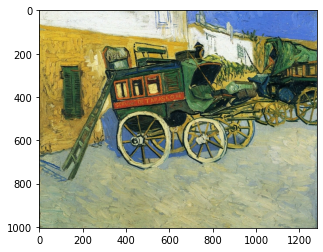

Henri_Matisse Impressionism b'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Impressionism/Henri_Matisse/Henri_Matisse_27.jpg'


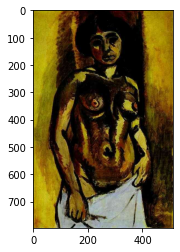

Pablo_Picasso Cubism b'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Cubism/Pablo_Picasso/Pablo_Picasso_200.jpg'


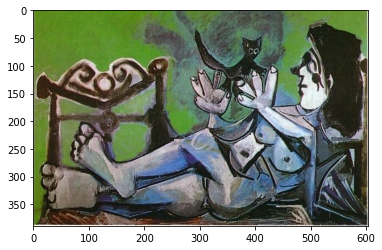

Amedeo_Modigliani Expressionism b'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Expressionism/Amedeo_Modigliani/Amedeo_Modigliani_72.jpg'


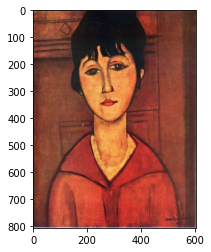

Rembrandt Baroque b'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Baroque/Rembrandt/Rembrandt_53.jpg'


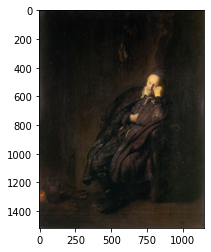

In [ ]:
for f in train_ds.take(5):
  string = f.numpy()
  artist = string.decode().split('/')[-2]
  label = string.decode().split('/')[-3]
  bits = tf.io.read_file(string)
  image = tf.io.decode_jpeg(bits)
  print(artist, label, string)
  plt.imshow(image)
  plt.show()

In [ ]:
  # features = {
  #   "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
  #   "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
  #   "one_hot_class": tf.io.VarLenFeature(tf.float32),
  # }
  # tf.io.parse_single_example(train_ds.take(1).numpy(), features)

In [ ]:
# def attempt(ds):
#   for f in ds.take():
#     string = f.numpy()
#     artist = string.decode().split('/')[-2]
#     label = string.decode().split('/')[-3]
#     bits = tf.io.read_file(string)
#     image = tf.io.decode_jpeg(bits)
#     # print(artist, label, string)
#     # plt.imshow(image)
#   return string, label


In [ ]:
N_CLASSES = train_df.simpleGenre.nunique()

NameError: ignored

In [ ]:
# def load_dataset(filenames):
#   # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
#   # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
#   # to allow order-altering optimizations.

#   option_no_order = tf.data.Options()
#   option_no_order.experimental_deterministic = False

#   dataset = tf.data.Dataset.from_tensor_slices(filenames)
#   dataset = dataset.with_options(option_no_order)
#   dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
#   dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
#   return dataset


In [ ]:
EFF_SHAPE

In [ ]:
for f in train_ds.take(1):
  print(f.numpy())

b'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Expressionism/Amedeo_Modigliani/Amedeo_Modigliani_130.jpg'


In [ ]:
def parse_tfrecord(example, EFF_SHAPE=EFF_SHAPE, N_CLASSES=N_CLASSES):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  tfre
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  # normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(decoded, [224,224,3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [N_CLASSES])
  return image_tensor, one_hot_class

In [ ]:
train_ds = train_ds.map(parse_tfrecord)
test_ds = test_ds.map(parse_tfrecord)

In [ ]:
train_ds

NameError: ignored

In [ ]:
train_ds.map()

AttributeError: ignored

In [ ]:
# for f in train_ds.take(2):
#   print(f.numpy())

# for f in train_ds.labels.take(2):
#   print(f)

In [ ]:
# def get_dataset_iterator(dataset, n_examples):
#   return dataset.unbatch().batch(n_examples).as_numpy_iterator()

# trial = get_dataset_iterator(train_ds, 1)

In [ ]:
# for f in train_ds.take(2):
#   f.map(parse_tfrecord)

In [ ]:
def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  return image



In [ ]:
# train_ds = train_ds.map(decode_jpeg, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.map(decode_jpeg, num_parallel_calls=AUTOTUNE)

In [ ]:
# for data in train_ds:
#   print(data)
#   break

In [ ]:
# train = tf.data.TFRecordDataset(TRAIN_URL, num_parallel_reads=AUTOTUNE)
# test = tf.data.TFRecordDataset(TEST_URL, num_parallel_reads=AUTOTUNE)

In [ ]:
# for batch in train.map(lambda x: tf.image.decode_jpeg(x, channels=3)):
#   print(batch)
#   break

In [ ]:
# gs://kds-f202029e33e4e8db36e09c2c0eba6e410dd2e8d04bbeba35f36f67b7/artists.csv
# images = 'gs://kds-f202029e33e4e8db36e09c2c0eba6e410dd2e8d04bbeba35f36f67b7/images/*/*'

In [ ]:
# from kaggle_datasets import KaggleDatasets
# GCS_PATH = KaggleDatasets().get_gcs_path()
# !gsutil ls $GCS_PATH

In [ ]:
# train = tfds.load(name="artTrain", split='train', data_dir=TEST_URL)

In [ ]:
lookup2

,name,simpleGenre,path,img_name
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_42.jpg
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_85.jpg
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_166.jpg
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_188.jpg
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_92.jpg
...,...,...,...,...
8113,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_8.jpg
8114,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_19.jpg
8115,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_22.jpg
8116,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_6.jpg


In [ ]:
lookup2['img_name'] = [i.split('/')[-1] for i in lookup2.path]
lookup2

,name,simpleGenre,path,img_name
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_42.jpg
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_85.jpg
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_166.jpg
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_188.jpg
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_92.jpg
...,...,...,...,...
8113,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_8.jpg
8114,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_19.jpg
8115,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_22.jpg
8116,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_6.jpg


In [ ]:
# TEST_URL

In [ ]:
test_filenames = tf.io.gfile.glob(f'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/*/*/*.jpg')
test_filenames[:5]

['gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_14.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_16.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_4.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_6.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/test/content/test/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_7.jpg']

In [ ]:
TRAIN_URL

'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/*/*/*/*/*/'

In [ ]:
train_filenames = tf.io.gfile.glob(f'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/*/*/*/*/*.jpg')
train_filenames[:5]

['gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_1.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_10.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_11.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_12.jpg',
 'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/content/train/Abstract Expressionism/Jackson_Pollock/Jackson_Pollock_13.jpg']

In [ ]:
test_df = lookup2.merge(gs, on='img_name')
train_df = lookup2.merge(gs2, on='img_name')

In [ ]:
test_df

,name,simpleGenre,path,img_name,gs_path
0,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_92.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
1,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_117.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
2,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_153.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
3,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_156.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
4,Amedeo_Modigliani,Expressionism,/content/images/images/Amedeo_Modigliani/Amede...,Amedeo_Modigliani_177.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
...,...,...,...,...,...
1619,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_4.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
1620,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_16.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
1621,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_14.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...
1622,Jackson_Pollock,Abstract Expressionism,/content/images/images/Jackson_Pollock/Jackson...,Jackson_Pollock_6.jpg,gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1...


In [ ]:
# dls = ImageDataGenerator(rotation_range=90,
#                         width_shift_range=100,
#                         height_shift_range=200,
#                         brightness_range=[-.5,.5],
#                         shear_range=.2,
#                         zoom_range=.5,
#                         horizontal_flip=True,
#                         vertical_flip=True,
#                         # rescale=1/255,  #  Not needed for efficientnets
#                         dtype=tf.float32,
#                         validation_split=0.2)

In [ ]:
# train, test = TTS(lookup3, test_size=.2, stratify=lookup3['simpleGenre'])

In [ ]:
BATCH_SIZE

64

In [ ]:
# dl_train = dls.flow_from_dataframe(train_df,
#                                   x_col='gs_path', 
#                                   y_col="simpleGenre",
#                                   target_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                   class_mode='categorical',
#                                   batch_size=BATCH_SIZE,
#                                   # subset='training'
#                                   )

# dl_test = dls.flow_from_dataframe(test_df,
#                                   x_col='gs_path', 
#                                   y_col="simpleGenre",
#                                   target_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                   class_mode='categorical',
#                                   batch_size=BATCH_SIZE,
#                                   # subset='validation'
#                                   )


Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6494 invalid image filename(s) in x_col="gs_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1624 invalid image filename(s) in x_col="gs_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
CLASSES = []
class_strings = tf.io.gfile.glob(TEST_URL[:-5])
for cls in class_strings:
  CLASSES.append(cls.split('/')[-1])
assert len(set(CLASSES)) == 21

In [ ]:
CLASSES = []
class_strings = tf.io.gfile.glob(TRAIN_URL[:-5])
for cls in class_strings:
  CLASSES.append(cls.split('/')[-1])
assert len(set(CLASSES)) == 21

In [ ]:
TRAIN_URL[:-7]

'gs://kds-dff7eb4eafdf794be54ae824310f58aee20a1b1fe6e66a686b44ee3c/train/*/*'

In [ ]:
# train_ds = tf.keras.utils.image_dataset_from_directory(TRAIN_URL, 
#                                                        labels='inferred', 
#                                                        label_mode='categorical',
#                                                        batch_size=BATCH_SIZE,
#                                                        image_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                                        shuffle=True,
#                                                        crop_to_aspect_ratio=False)
# test_ds = tf.keras.utils.image_dataset_from_directory(TEST_URL,
#                                                       labels='inferred',
#                                                       label_mode='categorical',
#                                                       batch_size=BATCH_SIZE,
#                                                       image_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                                       shuffle=True,
#                                                       crop_to_aspect_ratio=False)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# On GPU, remember .cache()

train_ds = train_ds.cache().shuffle(2000).batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# can also change how the flow from dataframe is 

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/smart_resize



In [ ]:
# dls = ImageDataGenerator(rotation_range=90,
#                         width_shift_range=100,
#                         height_shift_range=200,
#                         brightness_range=[-.5,.5],
#                         shear_range=.2,
#                         zoom_range=.5,
#                         horizontal_flip=True,
#                         vertical_flip=True,
#                         # rescale=1/255,  #  Not needed for efficientnets
#                         dtype=tf.float32,
#                         validation_split=0.2)

In [ ]:
lookup2.dtypes

name           object
simpleGenre    object
path           object
dtype: object

In [ ]:
# dl_train = dls.flow_from_dataframe(lookup2,
#                                   x_col='path', 
#                                   y_col=["name", "simpleGenre"],
#                                   target_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                   class_mode='raw',
#                                   batch_size=BATCH_SIZE,
#                                   subset='training'
#                                   )

# dl_test = dls.flow_from_dataframe(lookup2,
#                                   x_col='path',
#                                   y_col=["name", "simpleGenre"], 
#                                   target_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                   class_mode='raw',
#                                   batch_size=BATCH_SIZE,
#                                   subset='validation'
#                                   )


In [ ]:
# dl_train = dls.flow_from_dataframe(lookup2,
#                                   x_col='path', 
#                                   y_col="simpleGenre",
#                                   target_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                   class_mode='categorical',
#                                   batch_size=8,
#                                   subset='training'
#                                   )

# dl_test = dls.flow_from_dataframe(lookup2,
#                                   x_col='path',
#                                   y_col="simpleGenre", 
#                                   target_size=(EFF_SHAPE[0], EFF_SHAPE[0]),
#                                   class_mode='categorical',
#                                   batch_size=8,
#                                   subset='validation'
#                                   )


In [ ]:
# !pip install efficientnet

In [ ]:
# !wget https://github.com/xhlulu/keras-noisy-student/releases/download/data/efficientnet-l2_noisy-student_notop.h5

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
# model = efn.EfficientNetL2(weights="/content/efficientnet-l2_noisy-student_notop.h5", include_top=False)

In [ ]:
# import efficientnet.tfkeras as efn 
# from tensorflow.keras.models import load_model

# model = load_model("/content/efficientnet-l2_noisy-student_notop.h5")

In [ ]:
# With mixed precision, batch_size*=2
policy = tf.keras.mixed_precision.Policy('mixed_bfloat16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
N_GENRES = lookup2.simpleGenre.nunique()

In [ ]:
for x, y in train_ds.take(1):
  print(y)

TypeError: ignored

In [ ]:
def modelgen(N_GENRES=N_GENRES, diagnostic=False):
  model = EfficientNetB7(
    include_top=False, weights='imagenet',
    # input_shape=None,
    pooling='max',)
  
  inputs = tf.keras.layers.Input(shape=EFF_SHAPE)
  x = model(inputs)
  outputs = tf.keras.layers.Dense(N_GENRES, activation='softmax')(x)

  mlc = tf.keras.Model(inputs=inputs, outputs=outputs) 
  
  if diagnostic==True:
    return mlc, model
  else:
    return mlc


with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  mlc = modelgen()
  mlc.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=.1), 
              metrics='accuracy')

  mlc.fit(train_ds,
        # steps_per_epoch=int(len(X_train)/BATCH_SIZE),
        # validation_data=test_ds,
        # validation_steps=int(len(X_test)*.2), 
        epochs=5,
        # callbacks=[checkpoint_callback]
        )

mlc.summary()

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
_, model = modelgen(diagnostic=True)
for n, layer in enumerate(model.layers):
  print(layer)

In [ ]:
# Okay, so normalization is included in layers as is pooling, can pass directly to dense

In [ ]:
!mkdir mdl0

In [ ]:
# Setup checkpoint path
checkpoint_path = "/content/mdl0/" # note: remember saving directly to Colab is temporary

# for TPU, must save locally
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        #  save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         options=save_locally,
                                                         verbose=1)

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224), (None, 21)), types: (tf.uint8, tf.float32)>

In [ ]:
tf.config.experimental_run_functions_eagerly(False)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 21)), types: (tf.uint8, tf.float32)>

Epoch 1/5


TypeError: ignored

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  mlc0 = modelgen()
  mlc.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=.1), 
              metrics='accuracy')

In [ ]:
# dl_train.__getitem__(0)

In [ ]:
EFF_SHAPE

(224, 224, 3)

In [ ]:
# # Use a tf optimizer rather than a Keras one for now
# opt = tf.train.AdamOptimizer()
# model.compile(
#       optimizer=opt,
#       loss='categorical_crossentropy',
#       metrics=['acc'])

In [ ]:
# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     mlc,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))